In [29]:
# General imports
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Audio processing
import librosa
import librosa.display

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, class_weight

# Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [30]:
def load_dataset(path, label_mapping):
    """
    Recursively load .wav files from dataset, assign labels based on 'label_mapping'.
    Files containing any key in label_mapping will be assigned to the corresponding label.
    Unmatched or unlabelled files are skipped.
    """
    if not os.path.exists(path):
        print(f"Warning: Directory {path} not found.")
        return pd.DataFrame()

    pattern = os.path.join(path, "**", "*.wav")
    wav_files = glob.glob(pattern, recursive=True)
    if not wav_files:
        print(f"Warning: No .wav files found in {path}")
        return pd.DataFrame()

    data = []
    for f in wav_files:
        fname = os.path.basename(f).lower()
        if "unlabelled" in fname:
            continue
        label = None
        for key, mapped in label_mapping.items():
            if key in fname:
                label = mapped
                break
        if label is None:
            continue
        # Get audio duration
        try:
            dur = librosa.get_duration(path=f)
        except Exception:
            continue
        # Slice into overlapping segments
        if dur >= 3:
            slice_dur, stride = 3.0, 1.5  # 50% overlap
            num = max(1, int((dur - slice_dur) / stride) + 1)
            for i in range(num):
                offset = min(i * stride, dur - slice_dur)
                data.append({"filename": f, "label": label, "offset": offset})
        else:
            data.append({"filename": f, "label": label, "offset": 0.0})

    df = pd.DataFrame(data)
    return shuffle(df, random_state=42) if not df.empty else df

In [31]:
def extract_features(audio_path, offset, duration=3):
    """Extract MFCC features from an audio file with consistent dimensions."""
    # Load audio file with specified offset and duration
    y, sr = librosa.load(audio_path, offset=offset, duration=duration)

    # Ensure audio is exactly the expected duration by padding with zeros or trimming
    expected_length = int(duration * sr)
    if len(y) < expected_length:
        y = np.pad(y, (0, expected_length - len(y)), "constant")
    elif len(y) > expected_length:
        y = y[:expected_length]

    # Generate mel spectrogram
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
    )

    # Generate MFCCs from mel spectrogram
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

    # Ensure consistent time dimension (frames)
    target_frames = (
        130  # This should be consistent for 3 second clips with hop_length=512
    )
    if mfccs.shape[1] < target_frames:
        padding = ((0, 0), (0, target_frames - mfccs.shape[1]))
        mfccs = np.pad(mfccs, padding, mode="constant")
    elif mfccs.shape[1] > target_frames:
        mfccs = mfccs[:, :target_frames]

    return mfccs

In [32]:
def visualize_dataset(df, samples=1):
    if df.empty:
        print("No data to visualize.")
        return

    labels = df.label.unique()

    for lbl in labels:
        subset = df[df.label == lbl].iloc[:samples]
        for _, row_data in subset.iterrows():
            y, sr = librosa.load(row_data.filename, offset=row_data.offset, duration=3)

            # Create figure with 3 subplots
            plt.figure(figsize=(18, 15))

            # Plot waveform
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y=y, sr=sr)
            plt.title(f"{lbl} Waveform", fontsize=16)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("Amplitude", fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)

            # Plot melspectrogram
            plt.subplot(3, 1, 2)
            S = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
            )
            librosa.display.specshow(
                librosa.power_to_db(S, ref=np.max), sr=sr, x_axis="time", y_axis="mel"
            )
            plt.colorbar(format="%+2.0f dB")
            plt.title(f"{lbl} MelSpec", fontsize=16)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("Mel Bands", fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)

            # Plot MFCC
            plt.subplot(3, 1, 3)
            mf = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
            librosa.display.specshow(mf, x_axis="time")
            plt.colorbar()
            plt.title(f"{lbl} MFCC", fontsize=16)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("MFCC Coefficients", fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)

            plt.tight_layout(pad=3.0)
            plt.subplots_adjust(hspace=0.3)
            plt.show()

In [33]:
def train_model():
    # Define label mappings for datasets
    map_a = {
        "normal": "normal",
        "murmur": "murmur",
        "extrahls": "extrahls",
        "artifact": "artifact",
    }
    map_b = {"normal": "normal", "murmur": "murmur", "extrastole": "extrasystole"}

    # Load and combine datasets
    df_a = load_dataset("data/set_a", map_a)
    df_b = load_dataset("data/set_b", map_b)
    df = pd.concat([df_a, df_b], ignore_index=True)
    if df.empty:
        print("No data loaded.")
        return
    print(f"Loaded {len(df)} segments across dataset.")
    print(df.label.value_counts())

    # Visualize class distribution
    plt.figure(figsize=(10, 6))

    class_colors = {
        "normal": "green",
        "murmur": "red",
        "extrahls": "blue",
        "artifact": "purple",
        "extrasystole": "orange",
    }

    counts = df.label.value_counts()

    ax = counts.plot(
        kind="bar",
        title="Combined Distribution",
        color=[class_colors.get(lbl, "gray") for lbl in counts.index],
    )

    for i, v in enumerate(counts):
        ax.text(i, v + 5, str(v), ha="center", fontweight="bold")

    plt.xlabel("Heart Sound Classes")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

    visualize_dataset(df)

    # Data preparation
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df.label
    )
    print(f"Train: {len(train_df)}, Test: {len(test_df)}")

    X_train = np.array(
        [
            extract_features(r.filename, r.offset)
            for _, r in tqdm(train_df.iterrows(), total=len(train_df))
        ]
    )
    X_test = np.array(
        [
            extract_features(r.filename, r.offset)
            for _, r in tqdm(test_df.iterrows(), total=len(test_df))
        ]
    )

    # Label encoding and class weights
    encoder = LabelEncoder()
    encoder.fit(train_df.label)
    y_train = encoder.transform(train_df.label)
    y_test = encoder.transform(test_df.label)
    cw_vals = class_weight.compute_class_weight(
        "balanced", classes=np.unique(y_train), y=y_train
    )
    cw = {i: cw_vals[i] for i in range(len(cw_vals))}
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Model architecture
    model = Sequential(
        [
            Conv2D(32, 3, activation="relu", input_shape=X_train.shape[1:]),
            MaxPooling2D(),
            Dropout(0.2),
            Conv2D(64, 3, activation="relu"),
            MaxPooling2D(),
            Dropout(0.2),
            Conv2D(128, 3, activation="relu"),
            MaxPooling2D(),
            Dropout(0.3),
            Conv2D(256, 3, activation="relu"),
            GlobalAveragePooling2D(),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(len(encoder.classes_), activation="softmax"),
        ]
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"],
    )
    model.summary()

    # Training setup
    os.makedirs("models", exist_ok=True)
    cp = ModelCheckpoint(
        "models/heartbeat_classifier_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    )
    es = EarlyStopping("val_loss", patience=20, restore_best_weights=True)

    # Model training
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=100,
        callbacks=[cp, es],
        class_weight=cw,
        shuffle=True,
    )

    # Visualization of training metrics
    plt.figure(figsize=(18, 8))

    plt.subplot(121)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.legend()
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")

    plt.subplot(122)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="validation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    # Model evaluation
    loss, acc = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {acc}")
    preds = model.predict(X_test)
    y_true = encoder.inverse_transform(np.argmax(y_test, axis=1))
    y_pred = encoder.inverse_transform(np.argmax(preds, axis=1))
    print(classification_report(y_true, y_pred))

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred, labels=encoder.classes_)
    plt.figure(figsize=(10, 8))

    row_sums = np.sum(cm, axis=1)

    cm_percentages = np.zeros_like(cm, dtype=float)
    for i in range(len(encoder.classes_)):
        if row_sums[i] > 0:
            cm_percentages[i, i] = (cm[i, i] / row_sums[i]) * 100

    plt.imshow(cm, cmap="Blues")
    plt.colorbar(label="Count")
    plt.xticks(range(len(encoder.classes_)), encoder.classes_, rotation=45)
    plt.yticks(range(len(encoder.classes_)), encoder.classes_)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] == 0:
                continue

            text_color = "white" if cm[i, j] > cm.max() / 2 else "black"

            if i == j:
                plt.text(
                    j,
                    i,
                    f"{cm[i, j]}/{row_sums[i]} ({cm_percentages[i, j]:.1f}%)",
                    ha="center",
                    va="center",
                    color=text_color,
                )
            else:
                plt.text(
                    j, i, f"{cm[i, j]}", ha="center", va="center", color=text_color
                )

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Save model
    model.save("models/heartbeat_classifier_final.keras")


Loaded 1963 segments across dataset.
label
normal          1083
murmur           496
artifact         200
extrasystole     117
extrahls          67
Name: count, dtype: int64


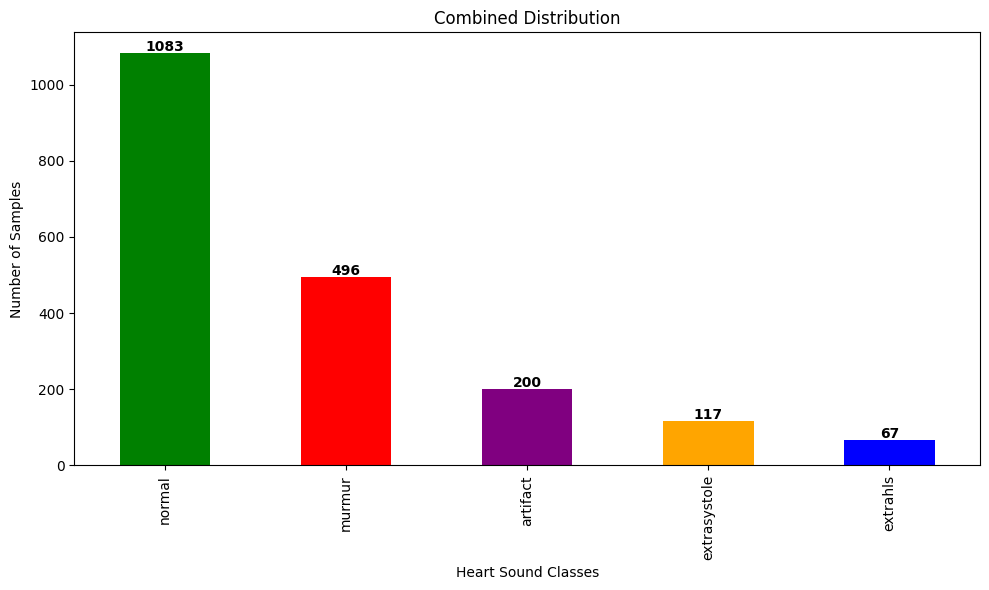

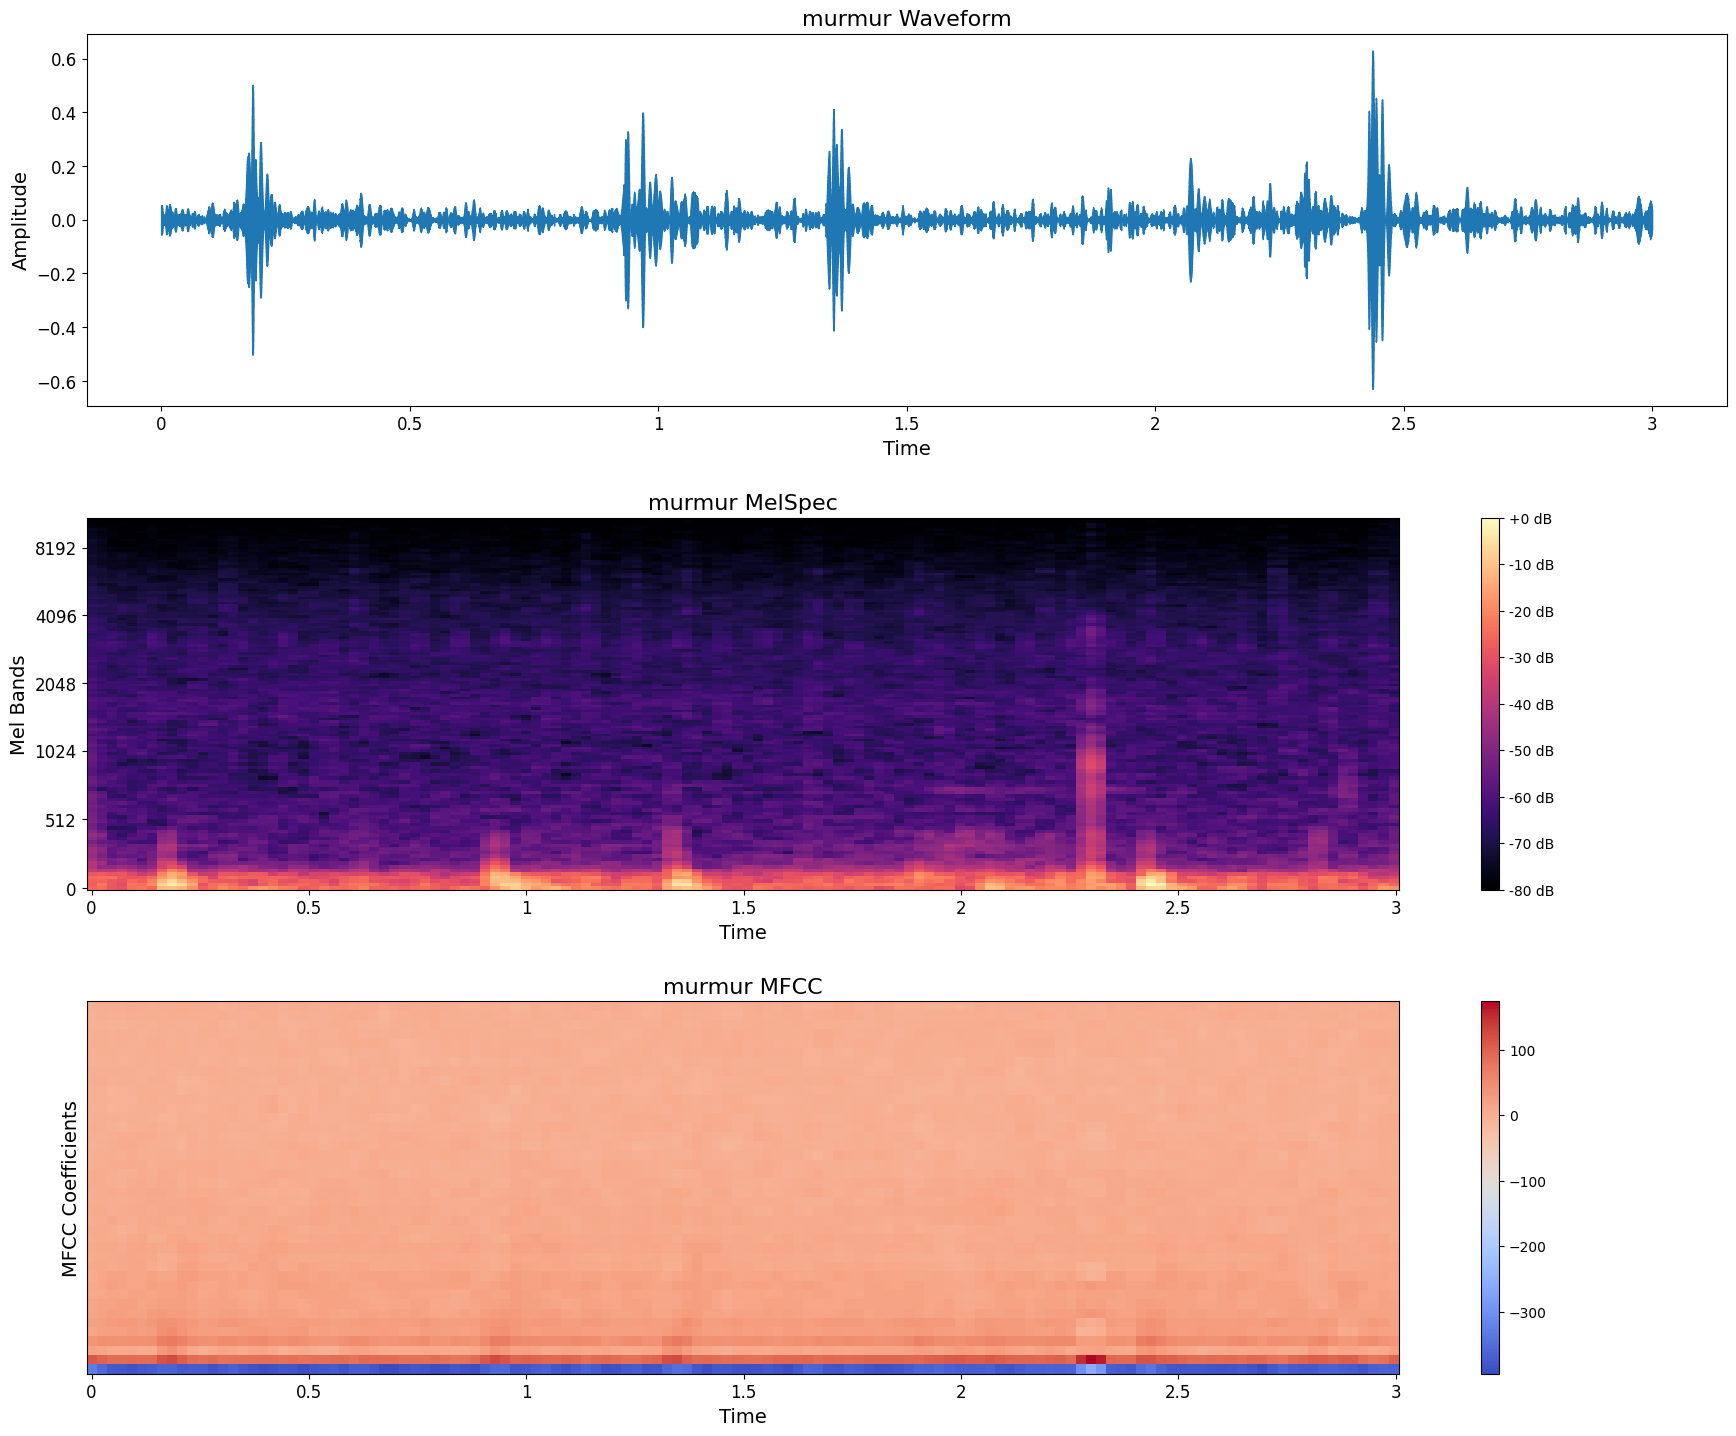

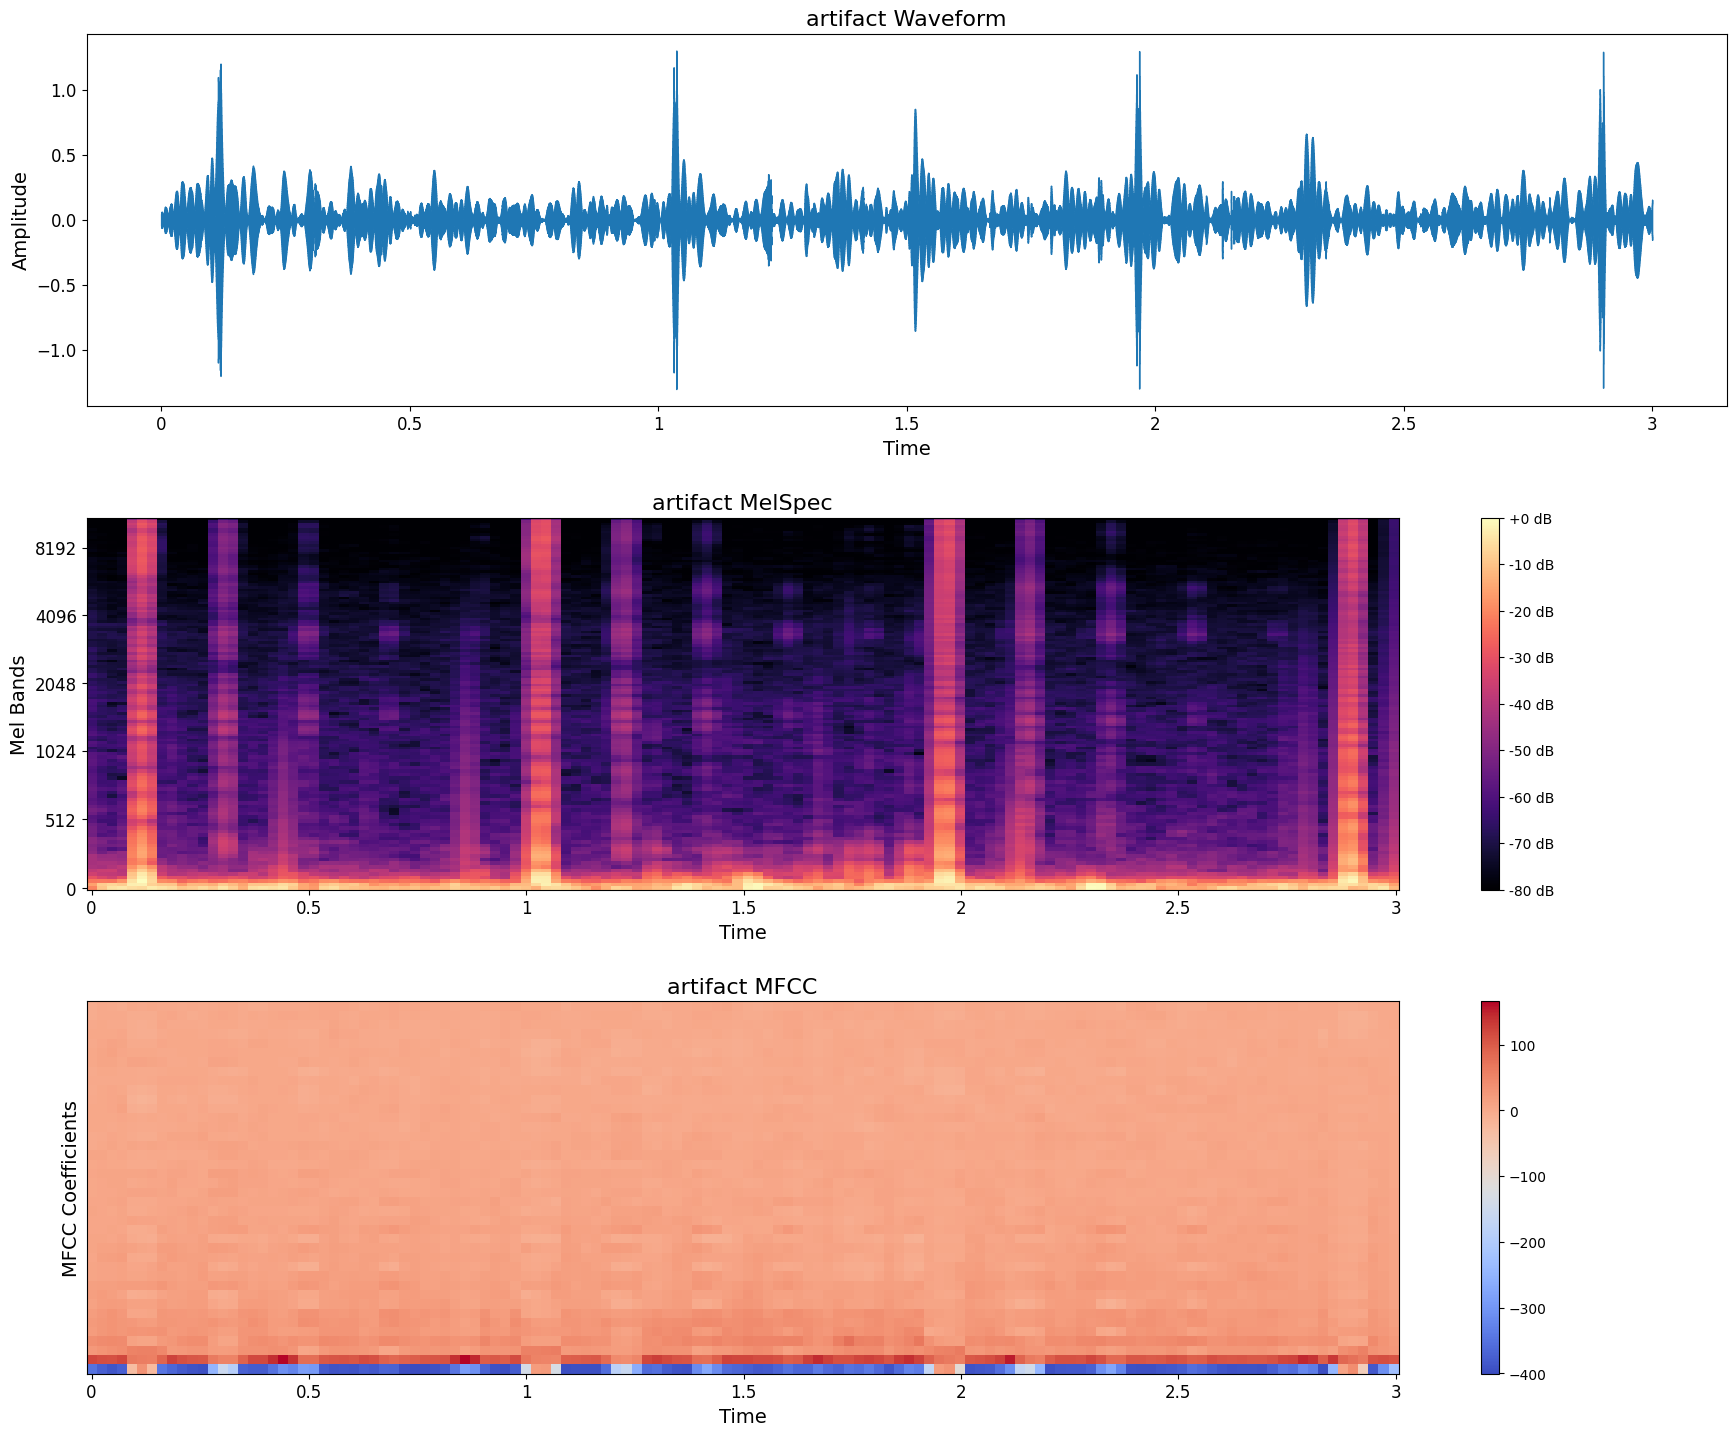

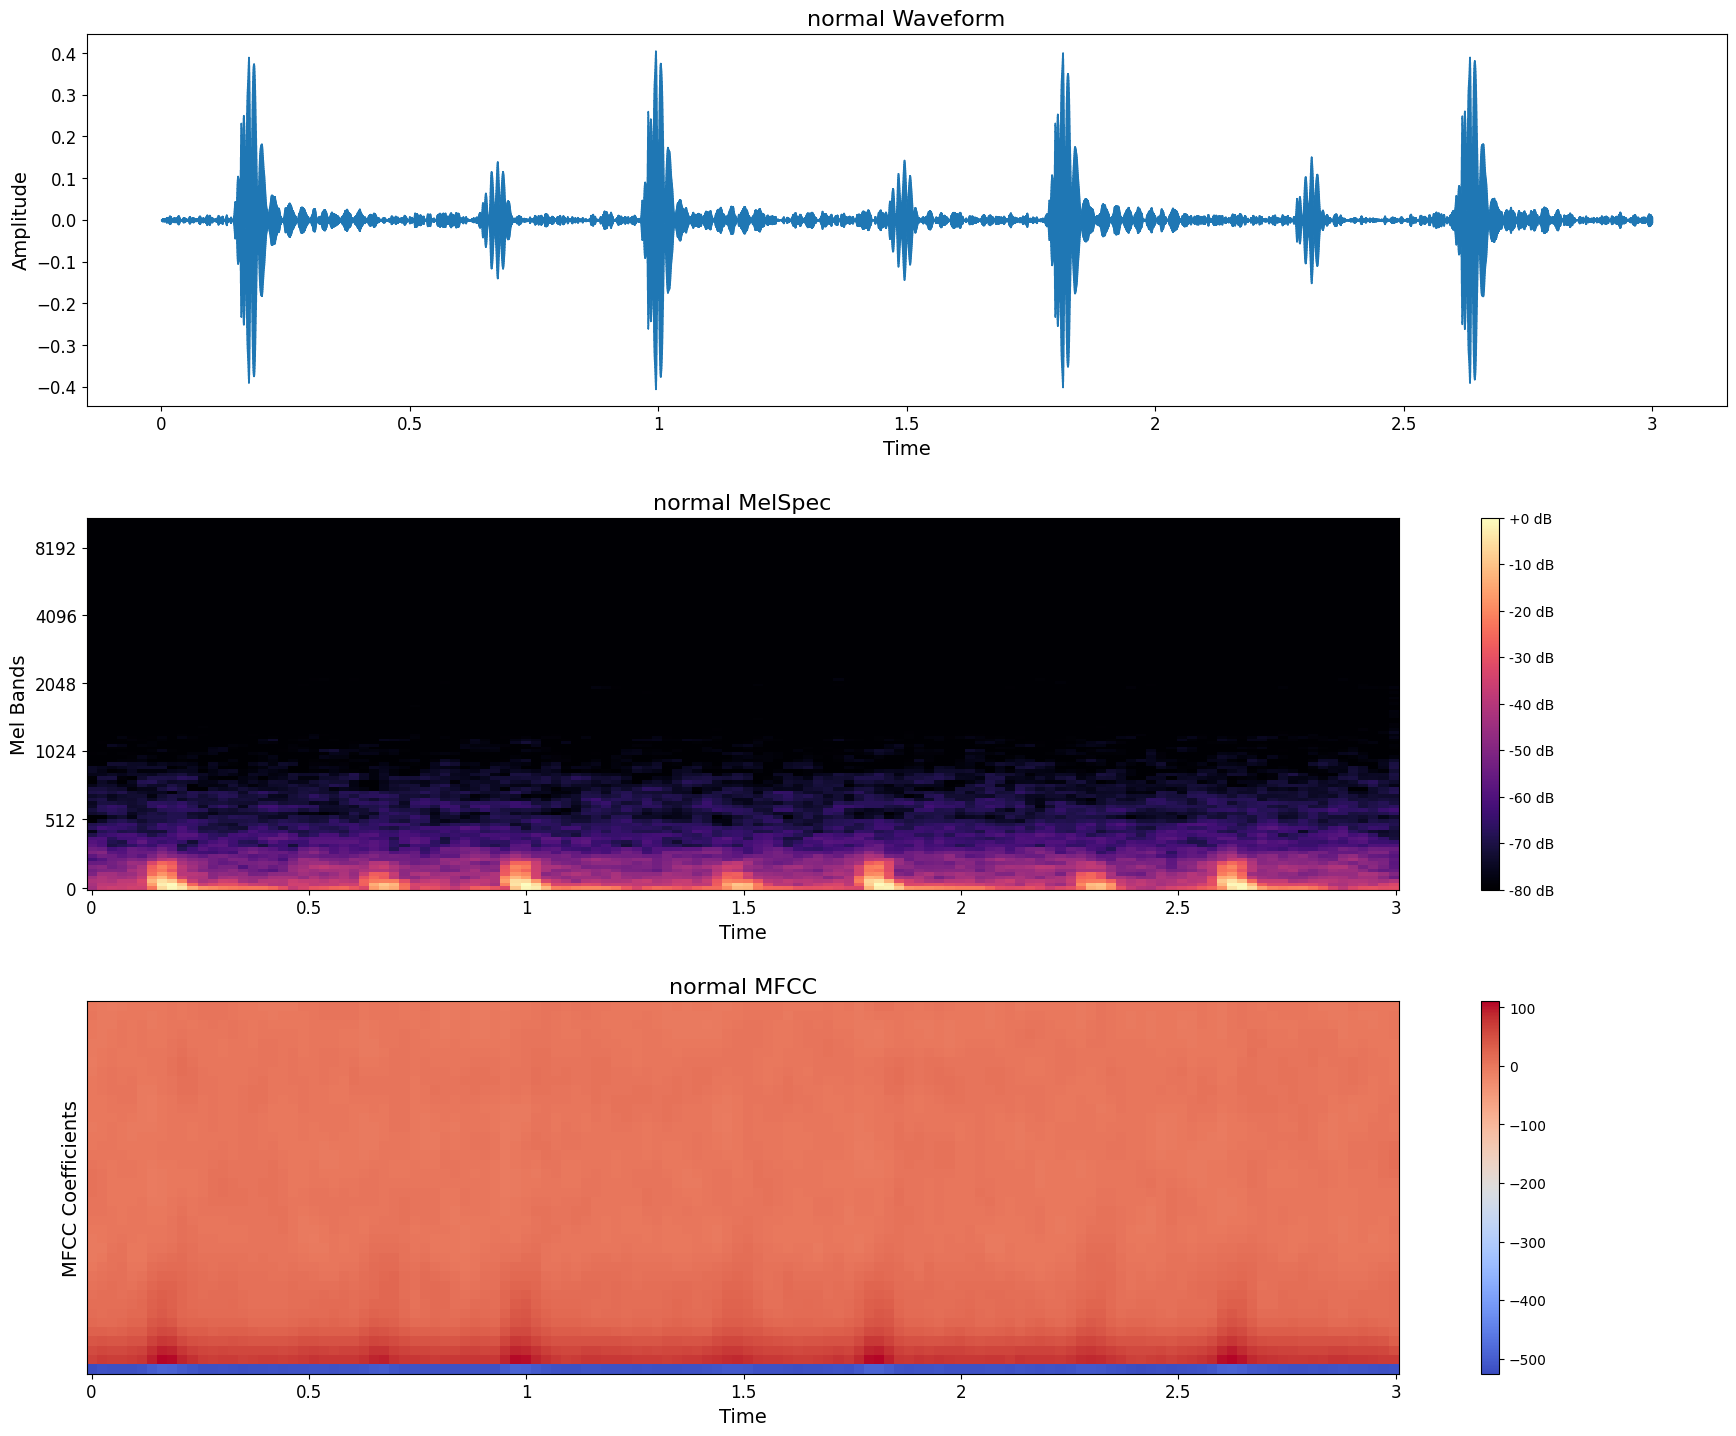

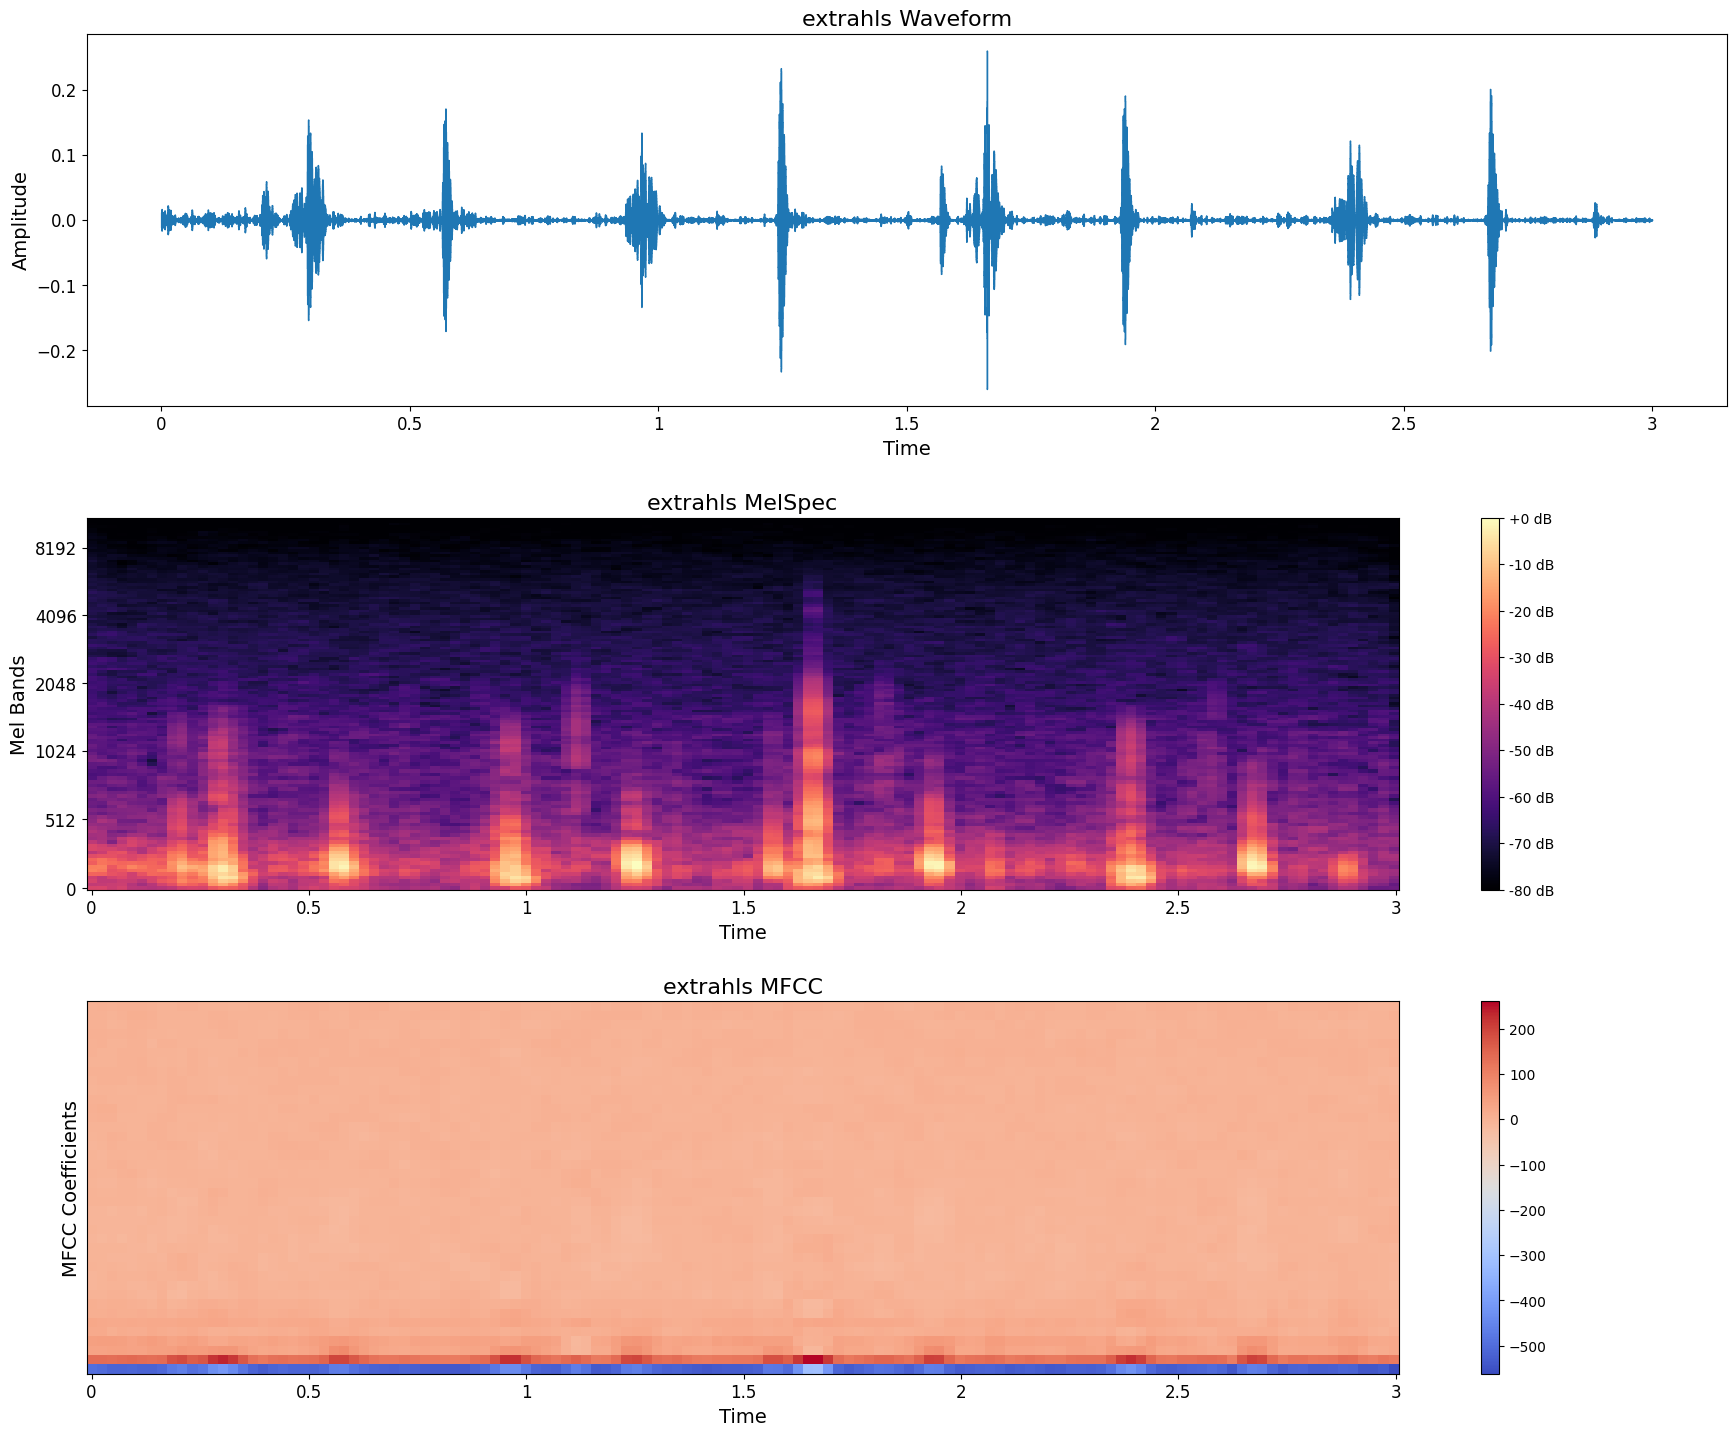

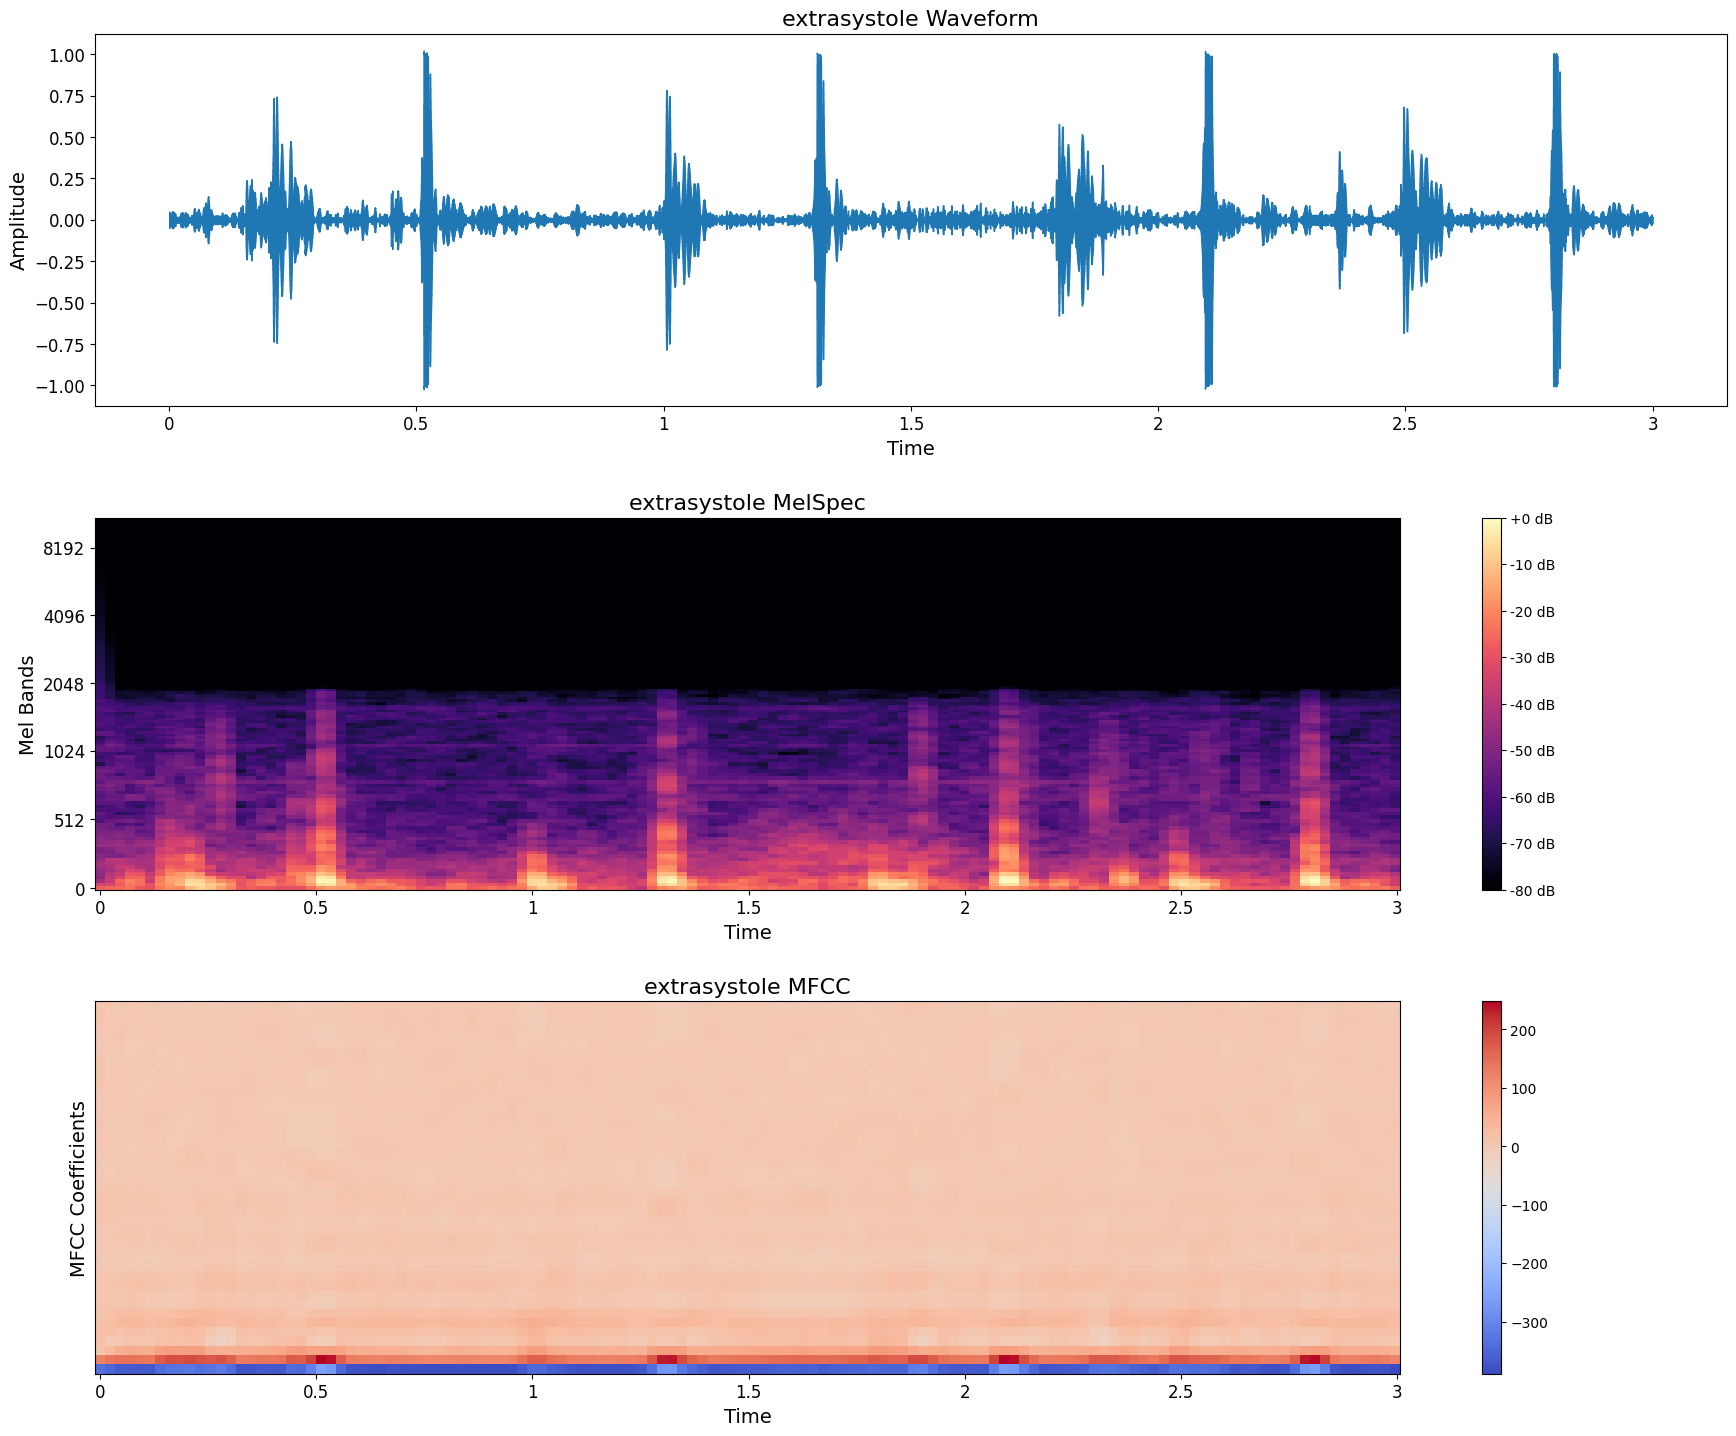

Train: 1570, Test: 393


100%|██████████| 393/393 [00:02<00:00, 167.30it/s]
c:\Users\Admin\Desktop\ai_projects\heartbeat_classifier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 38, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 17, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 6, 29, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 12, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,381 (1.61 MB)

 Trainable params: 421,381 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2650 - loss: 2.4928
Epoch 1: val_accuracy improved from -inf to 0.67430, saving model to models/heartbeat_classifier_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2675 - loss: 2.4568 - val_accuracy: 0.6743 - val_loss: 1.1391
Epoch 2/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3748 - loss: 0.9753
Epoch 2: val_accuracy did not improve from 0.67430
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3762 - loss: 0.9739 - val_accuracy: 0.4885 - val_loss: 1.1233
Epoch 3/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5113 - loss: 0.8485
Epoch 3: val_accuracy improved from 0.67430 to 0.69466, saving model to models/heartbeat_classifier_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5117 - loss: 0.8467 - val_accuracy: 0.6947 - val_loss: 0.9737
Epoch 4/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5376 - loss: 0.7338
Epoch 4: val_accuracy did not improve 

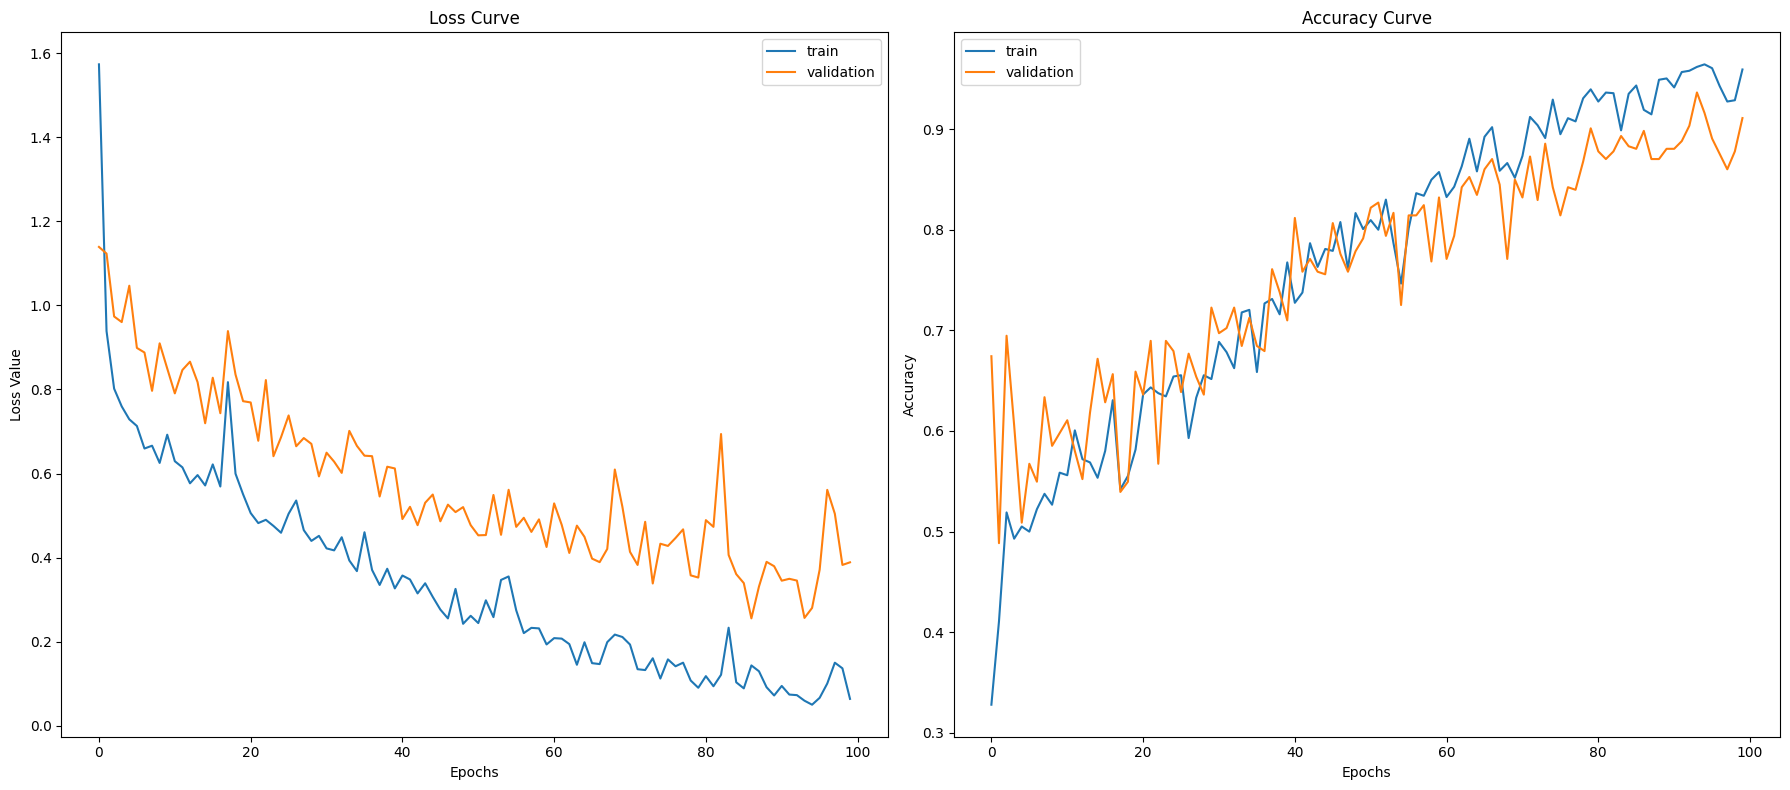

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8897 - loss: 0.2790
Test Loss: 0.25545284152030945, Test Accuracy: 0.8982188105583191
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

    artifact       0.98      1.00      0.99        40
    extrahls       0.65      1.00      0.79        13
extrasystole       0.70      0.79      0.75        24
      murmur       0.88      0.92      0.90        99
      normal       0.95      0.88      0.91       217

    accuracy                           0.90       393
   macro avg       0.83      0.92      0.87       393
weighted avg       0.91      0.90      0.90       393



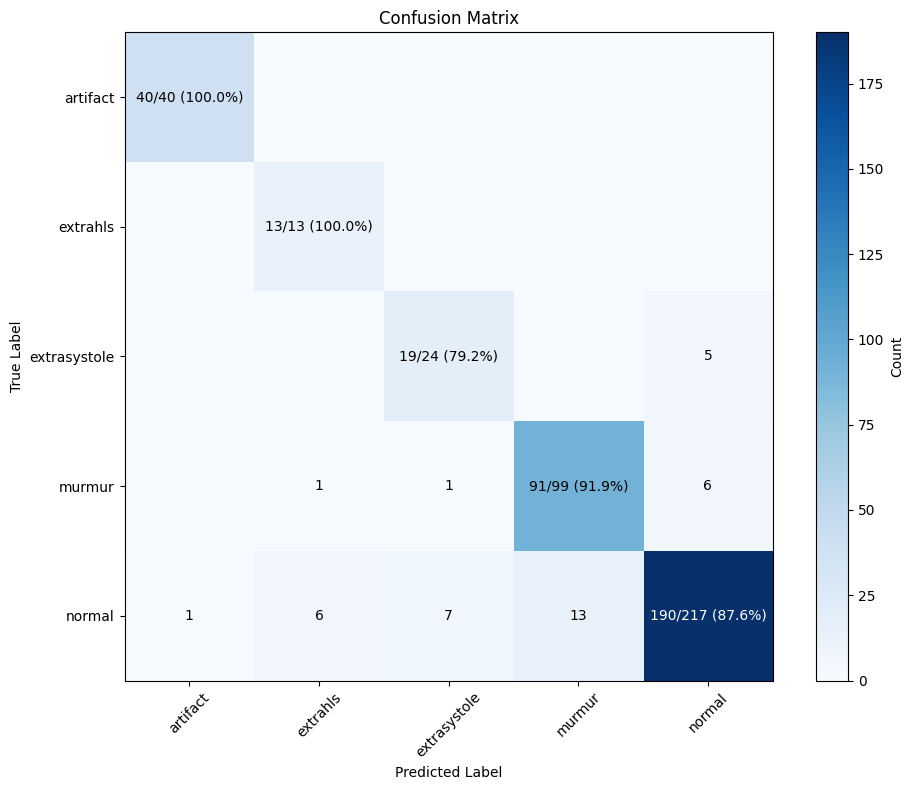

In [34]:
train_model()

In [35]:
# Load model
model = load_model("models/heartbeat_classifier_final.keras")

encoder = LabelEncoder()
encoder.classes_ = np.array(
    ["artifact", "extrahls", "extrasystole", "murmur", "normal"]
)

# File to classify
File_to_classify = "data/test/my_heartbeat.wav"

# Extract features
x_test = [extract_features(File_to_classify, 0.5)]
x_test = np.array(x_test)
x_test = x_test[..., np.newaxis]

# Predict
pred = model.predict(x_test, verbose=1)
pred_class = np.argmax(pred, axis=1)[0]
pred_label = encoder.inverse_transform([pred_class])[0]

# Output
print("Predicted Class:", pred_label)
print("Confidence:", pred[0][pred_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Class: normal
Confidence: 0.97281444
